In [1]:
%config InlineBackend.figure_format = "svg"

from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qbn import QuantumBayesianNetwork
from bn import BayesianNetwork
from qiskit import transpile
import pandas as pd

# Bayesian Network Class

## Create Bayesian Network Structure

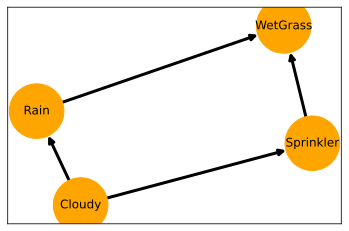

In [2]:
bn = BayesianNetwork()
bn.add_nodes(["Cloudy", "Sprinkler", "Rain", "WetGrass"])
bn.add_edges([("Cloudy", "Sprinkler"), ("Cloudy", "Rain"), ("Sprinkler", "WetGrass"), ("Rain", "WetGrass")])
bn.draw()

## Populate Bayesian Network with data

In [3]:
# Add data for node cloudy
data = {"Cloudy": [0,1], "Prob": [0.5,0.5]}
bn.add_node_pt("Cloudy", pd.DataFrame(data))

# Add data for node Sprinkler
data = {"Cloudy": [0,0,1,1], "Sprinkler": [0,1,0,1], "Prob": [0.5,0.5,0.9,0.1]}
bn.add_node_pt("Sprinkler", pd.DataFrame(data))

# Add data for node Cloudy
data = {"Cloudy": [0,0,1,1], "Rain": [0,1,0,1], "Prob": [0.8,0.2,0.2,0.8]}
bn.add_node_pt("Rain", pd.DataFrame(data))

# Add data for node WetGrass
data = {"Sprinkler": [0,0,0,0,1,1,1,1], "Rain": [0,0,1,1,0,0,1,1], "WetGrass": [0,1,0,1,0,1,0,1], "Prob": [1,0,0.1,0.9,0.1,0.9,0.01,0.99]}
bn.add_node_pt("WetGrass", pd.DataFrame(data))

## Apply sampling and get results

In [4]:
bn.sample(query=["Cloudy", "WetGrass"], evidence={"Rain": 1, "Sprinkler": 0}, n_samples=1000)

Prob
Cloudy WetGrass       
0      0         0.021
       1         0.097
1      0         0.075
       1         0.807

## Quantum Bayesian Networks

This first section's purpose is to represent the full joint distribution of the above bayesian network in a quantum circuit, so that we can get samples from the joint distribution just by performing measurements in the circuit.

A joint distribution in a BN with random variables $\mathcal{X} = \{X_1, \dots, X_n\}$ taking values $x_1, \dots, x_n$ can be mathematically described by the following equation:

$$ \mathbb{P} \left[ x_1, \dots, x_n \right] = \prod_{i=1}^{n} \mathbb{P} \left[ x_i \vert \text{parents}(x_i) \right] $$

By translating this equation to the example above, we get:

$$ \mathbb{P} \left[ c, r, s, w \right] = \mathbb{P} \left[ c \right] \mathbb{P} \left[ r \vert c \right] \mathbb{P} \left[ s \vert c \right] \mathbb{P} \left[ w \vert r, s \right] $$

In a general case, translating a BN into a quantum circuit involves applying a controlled rotation gate $\hat{U}_i$ on the target qubit of the random variable $X_i$, controlled by the qubits of the random variables that are parents of the target qubit, $\text{parents}(X_i)$.

This gate should perform a controlled $RY(\theta_i)$ rotation about the y-axis. Suppose $P_i = \{P_{i1}, \dots, P_{im}\}$ are the parent random variables of the random variable $X_i$. The angle $\theta_i$ is given by the expression:

$$ \theta_i = 2 \arctan \left( \sqrt{ \frac{ \mathbb{P} \left[ X_i = 1 \vert P_{i1} = 1, \dots, P_{im} = 1 \right] }{ \mathbb{P} \left[ X_i = 0 \vert P_{i1} = 1, \dots, P_{im} = 1 \right] } } \right) $$

In [5]:
qbn = QuantumBayesianNetwork(bn)

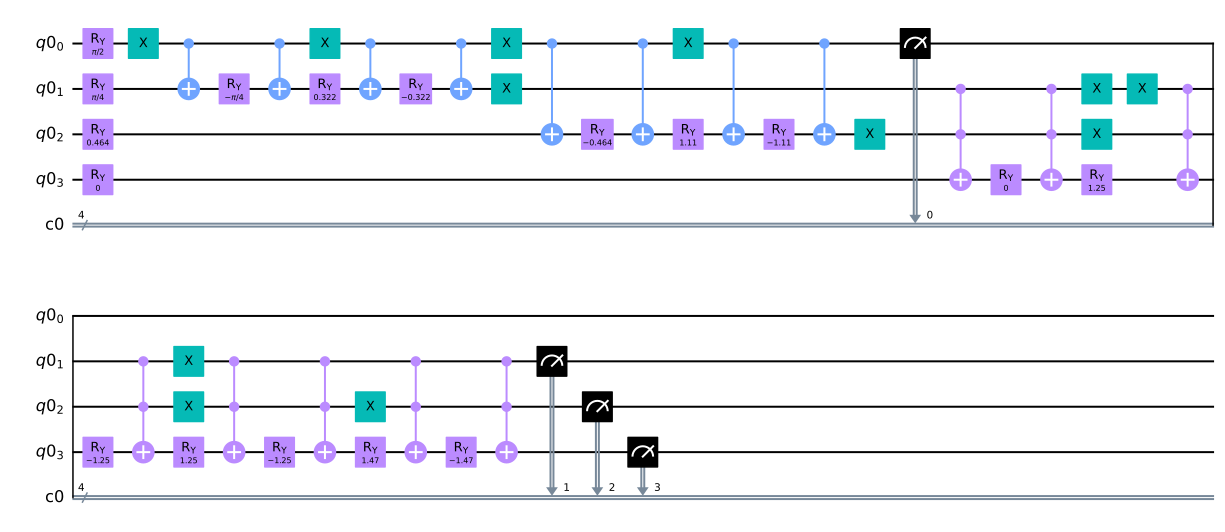

In [6]:
circuit = qbn.build()
circuit.draw(output="mpl")

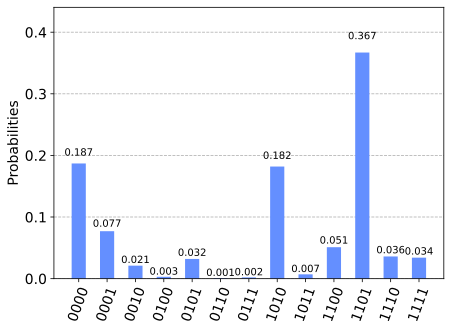

In [7]:
simulator = QasmSimulator()
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=1000)
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)